In [109]:
import pandas as pd
import numpy as np
import os, random, math, glob
from IPython.display import Image as IM
from IPython.display import clear_output
from matplotlib import pyplot as plt
import tqdm
%matplotlib inline
from catboost import CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GroupKFold, train_test_split
import re
from sklearn.preprocessing import LabelEncoder
#from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
import lightgbm as lgb
from category_encoders import *
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
plt.rcParams['figure.figsize'] = [5, 5]
pd.set_option('display.max_columns', None)

import numpy as np
import pandas as pd
from sklearn import metrics, preprocessing, model_selection

In [536]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission_iA3afxn.csv')

In [537]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [538]:
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [539]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [540]:
test.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

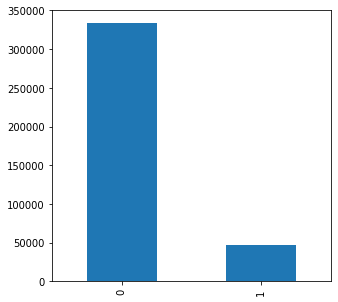

In [541]:
# Checking the Target Variable
train['Response'].value_counts().plot(kind='bar')

In [542]:
# getting the counts of each customer
for cols in train.columns:
    print('------------------------------------')
    print(train[cols].value_counts())

------------------------------------
2047      1
295621    1
84604     1
82557     1
88702     1
         ..
107934    1
109983    1
21920     1
23969     1
2049      1
Name: id, Length: 381109, dtype: int64
------------------------------------
Male      206089
Female    175020
Name: Gender, dtype: int64
------------------------------------
24    25960
23    24256
22    20964
25    20636
21    16457
      ...  
81       56
82       29
83       22
84       11
85       11
Name: Age, Length: 66, dtype: int64
------------------------------------
1    380297
0       812
Name: Driving_License, dtype: int64
------------------------------------
28.0    106415
8.0      33877
46.0     19749
41.0     18263
15.0     13308
30.0     12191
29.0     11065
50.0     10243
3.0       9251
11.0      9232
36.0      8797
33.0      7654
47.0      7436
35.0      6942
6.0       6280
45.0      5605
37.0      5501
18.0      5153
48.0      4681
14.0      4678
39.0      4644
10.0      4374
21.0      4266
2.0       

In [543]:
print(train.shape)
print(test.shape)

(381109, 12)
(127037, 11)


In [544]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [545]:
# map them
train['Vehicle_Age'] = train['Vehicle_Age'].replace({'1-2 Year':1, '< 1 Year':0, '> 2 Years':2})
# map them
test['Vehicle_Age'] = test['Vehicle_Age'].replace({'1-2 Year':1, '< 1 Year':0, '> 2 Years':2})

In [546]:
train['Vehicle_Damage'] = train['Vehicle_Damage'].map({'Yes':1, 'No':0})
test['Vehicle_Damage'] = test['Vehicle_Damage'].map({'Yes':1, 'No':0})

In [547]:
train['Gender'] = train['Gender'].astype('category').cat.codes
test['Gender'] = test['Gender'].astype('category').cat.codes

In [548]:
df = train.append(test, ignore_index=True, sort=False)

In [549]:
df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [550]:
df['Region_Count'] = df['Region_Code'].map(df['Region_Code'].value_counts())
#df['Policy_Sales_Channel_Count'] = df['Policy_Sales_Channel'].map(df['Policy_Sales_Channel'].value_counts())

In [551]:
df['policy_region'] = df['Policy_Sales_Channel'].astype(str) + '_' + df['Region_Code'].astype(str)

In [552]:
df['policy_region'] = df['policy_region'].astype('category').cat.codes

In [553]:
def aggregate_functions(df):        
    
    agg_func = {
        'Annual_Premium' : ['min', 'max', 'nunique', 'size','std', 'mean', 'median', 'sum'],
        'Vintage' : ['min', 'max', 'nunique', 'size','std', 'mean', 'median', 'sum'],
        'Region_Count' : ['min', 'max', 'std', 'mean', 'median', 'sum']}
    
    agg_df = df.groupby(['Region_Code']).agg(agg_func)
    agg_df.columns = ['_by_region_'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    agg_df = pd.merge(df, agg_df, on='Region_Code', how='left')
    
    return agg_df

In [554]:
df = aggregate_functions(df)

In [555]:
def aggregate_functions(df):        
    
    agg_func = {
        'Annual_Premium' : ['min', 'max', 'nunique', 'size','std', 'mean', 'median', 'sum'],
        'Vintage' : ['min', 'max', 'nunique', 'size','std', 'mean', 'median', 'sum'],
        'Region_Count' : ['min', 'max', 'std', 'mean', 'median', 'sum']
        }
    
    agg_df = df.groupby(['Policy_Sales_Channel']).agg(agg_func)
    agg_df.columns = ['_by_policy_'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    agg_df = pd.merge(df, agg_df, on='Policy_Sales_Channel', how='left')
    
    return agg_df

In [556]:
df = aggregate_functions(df)

In [557]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Region_Count,policy_region,Annual_Premium_by_region_min,Annual_Premium_by_region_max,Annual_Premium_by_region_nunique,Annual_Premium_by_region_size,Annual_Premium_by_region_std,Annual_Premium_by_region_mean,Annual_Premium_by_region_median,Annual_Premium_by_region_sum,Vintage_by_region_min,Vintage_by_region_max,Vintage_by_region_nunique,Vintage_by_region_size,Vintage_by_region_std,Vintage_by_region_mean,Vintage_by_region_median,Vintage_by_region_sum,Region_Count_by_region_min,Region_Count_by_region_max,Region_Count_by_region_std,Region_Count_by_region_mean,Region_Count_by_region_median,Region_Count_by_region_sum,Annual_Premium_by_policy_min,Annual_Premium_by_policy_max,Annual_Premium_by_policy_nunique,Annual_Premium_by_policy_size,Annual_Premium_by_policy_std,Annual_Premium_by_policy_mean,Annual_Premium_by_policy_median,Annual_Premium_by_policy_sum,Vintage_by_policy_min,Vintage_by_policy_max,Vintage_by_policy_nunique,Vintage_by_policy_size,Vintage_by_policy_std,Vintage_by_policy_mean,Vintage_by_policy_median,Vintage_by_policy_sum,Region_Count_by_policy_min,Region_Count_by_policy_max,Region_Count_by_policy_std,Region_Count_by_policy_mean,Region_Count_by_policy_median,Region_Count_by_policy_sum
0,1,1,44,1,28.0,0,2,1,40454.0,26.0,217,1.0,141937,1601,2630.0,540165.0,39411,141937,18483.115668,38649.878763,38717.0,5.485848e+09,10,299,290,141937,83.700191,154.266618,154.0,21896141,141937,141937,0.0,141937,141937,20146111969,2630.0,540165.0,35251,106594,18368.095093,33639.830863,34630.0,3.585804e+09,10,299,290,106594,83.816780,154.405070,154.0,16458654,271,141937,63486.388009,75448.754564,44900,8042384544
1,2,1,76,1,3.0,0,1,0,33536.0,26.0,183,0.0,12349,1603,2630.0,424578.0,7473,12349,14589.746562,24465.445218,26055.0,3.021238e+08,10,299,290,12349,82.796075,154.864442,154.0,1912421,12349,12349,0.0,12349,12349,152497801,2630.0,540165.0,35251,106594,18368.095093,33639.830863,34630.0,3.585804e+09,10,299,290,106594,83.816780,154.405070,154.0,16458654,271,141937,63486.388009,75448.754564,44900,8042384544
2,3,1,47,1,28.0,0,2,1,38294.0,26.0,27,1.0,141937,1601,2630.0,540165.0,39411,141937,18483.115668,38649.878763,38717.0,5.485848e+09,10,299,290,141937,83.700191,154.266618,154.0,21896141,141937,141937,0.0,141937,141937,20146111969,2630.0,540165.0,35251,106594,18368.095093,33639.830863,34630.0,3.585804e+09,10,299,290,106594,83.816780,154.405070,154.0,16458654,271,141937,63486.388009,75448.754564,44900,8042384544
3,4,1,21,1,11.0,1,0,0,28619.0,152.0,203,0.0,12328,862,2630.0,193637.0,7705,12328,14000.397877,27655.183160,29099.5,3.409331e+08,10,299,290,12328,83.740509,154.520360,154.0,1904927,12328,12328,0.0,12328,12328,151979584,2630.0,495106.0,38742,179523,14043.443197,30898.685511,30756.0,5.547025e+09,10,299,290,179523,83.624244,154.624338,155.0,27758625,271,141937,40038.624552,27787.879659,12349,4988563520
4,5,0,29,1,41.0,1,0,0,27496.0,152.0,39,0.0,24400,895,2630.0,339396.0,13801,24400,15174.548982,30948.979918,31623.5,7.551551e+08,10,299,290,24400,83.736493,154.851189,155.0,3778369,24400,24400,0.0,24400,24400,595360000,2630.0,495106.0,38742,179523,14043.443197,30898.685511,30756.0,5.547025e+09,10,299,290,179523,83.624244,154.624338,155.0,27758625,271,141937,40038.624552,27787.879659,12349,4988563520


In [558]:
train = df[df['Response'].isnull()!=True]
test = df[df['Response'].isnull()==True]
test.drop('Response', axis=1, inplace=True)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [559]:
test_id = test['id']

In [560]:
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

In [561]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Region_Count,policy_region,Annual_Premium_by_region_min,Annual_Premium_by_region_max,Annual_Premium_by_region_nunique,Annual_Premium_by_region_size,Annual_Premium_by_region_std,Annual_Premium_by_region_mean,Annual_Premium_by_region_median,Annual_Premium_by_region_sum,Vintage_by_region_min,Vintage_by_region_max,Vintage_by_region_nunique,Vintage_by_region_size,Vintage_by_region_std,Vintage_by_region_mean,Vintage_by_region_median,Vintage_by_region_sum,Region_Count_by_region_min,Region_Count_by_region_max,Region_Count_by_region_std,Region_Count_by_region_mean,Region_Count_by_region_median,Region_Count_by_region_sum,Annual_Premium_by_policy_min,Annual_Premium_by_policy_max,Annual_Premium_by_policy_nunique,Annual_Premium_by_policy_size,Annual_Premium_by_policy_std,Annual_Premium_by_policy_mean,Annual_Premium_by_policy_median,Annual_Premium_by_policy_sum,Vintage_by_policy_min,Vintage_by_policy_max,Vintage_by_policy_nunique,Vintage_by_policy_size,Vintage_by_policy_std,Vintage_by_policy_mean,Vintage_by_policy_median,Vintage_by_policy_sum,Region_Count_by_policy_min,Region_Count_by_policy_max,Region_Count_by_policy_std,Region_Count_by_policy_mean,Region_Count_by_policy_median,Region_Count_by_policy_sum
0,1,44,1,28.0,0,2,1,40454.0,26.0,217,1.0,141937,1601,2630.0,540165.0,39411,141937,18483.115668,38649.878763,38717.0,5.485848e+09,10,299,290,141937,83.700191,154.266618,154.0,21896141,141937,141937,0.0,141937,141937,20146111969,2630.0,540165.0,35251,106594,18368.095093,33639.830863,34630.0,3.585804e+09,10,299,290,106594,83.816780,154.405070,154.0,16458654,271,141937,63486.388009,75448.754564,44900,8042384544
1,1,76,1,3.0,0,1,0,33536.0,26.0,183,0.0,12349,1603,2630.0,424578.0,7473,12349,14589.746562,24465.445218,26055.0,3.021238e+08,10,299,290,12349,82.796075,154.864442,154.0,1912421,12349,12349,0.0,12349,12349,152497801,2630.0,540165.0,35251,106594,18368.095093,33639.830863,34630.0,3.585804e+09,10,299,290,106594,83.816780,154.405070,154.0,16458654,271,141937,63486.388009,75448.754564,44900,8042384544
2,1,47,1,28.0,0,2,1,38294.0,26.0,27,1.0,141937,1601,2630.0,540165.0,39411,141937,18483.115668,38649.878763,38717.0,5.485848e+09,10,299,290,141937,83.700191,154.266618,154.0,21896141,141937,141937,0.0,141937,141937,20146111969,2630.0,540165.0,35251,106594,18368.095093,33639.830863,34630.0,3.585804e+09,10,299,290,106594,83.816780,154.405070,154.0,16458654,271,141937,63486.388009,75448.754564,44900,8042384544
3,1,21,1,11.0,1,0,0,28619.0,152.0,203,0.0,12328,862,2630.0,193637.0,7705,12328,14000.397877,27655.183160,29099.5,3.409331e+08,10,299,290,12328,83.740509,154.520360,154.0,1904927,12328,12328,0.0,12328,12328,151979584,2630.0,495106.0,38742,179523,14043.443197,30898.685511,30756.0,5.547025e+09,10,299,290,179523,83.624244,154.624338,155.0,27758625,271,141937,40038.624552,27787.879659,12349,4988563520
4,0,29,1,41.0,1,0,0,27496.0,152.0,39,0.0,24400,895,2630.0,339396.0,13801,24400,15174.548982,30948.979918,31623.5,7.551551e+08,10,299,290,24400,83.736493,154.851189,155.0,3778369,24400,24400,0.0,24400,24400,595360000,2630.0,495106.0,38742,179523,14043.443197,30898.685511,30756.0,5.547025e+09,10,299,290,179523,83.624244,154.624338,155.0,27758625,271,141937,40038.624552,27787.879659,12349,4988563520


In [562]:
X = train.drop("Response", axis=1)
y = train["Response"]

In [563]:
#categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [567]:
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
errcb=[]
y_pred_totcb=[]
fold=StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
i=1
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    m = CatBoostClassifier(eval_metric='AUC', subsample=0.9, l2_leaf_reg=10)
    m.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)],
          verbose=50, early_stopping_rounds=100)#,verbose=100,cat_features=categorical_features_indices
    preds=m.predict_proba(X_test)[:, 1]
    print("err: ",roc_auc_score(y_test,preds))
    errcb.append(roc_auc_score(y_test,preds))
    p = m.predict_proba(test)[:, 1]
    y_pred_totcb.append(p)

0:	test: 0.8148502	test1: 0.8179156	best: 0.8179156 (0)	total: 366ms	remaining: 6m 5s
50:	test: 0.8539272	test1: 0.8567628	best: 0.8567628 (50)	total: 16.9s	remaining: 5m 14s
100:	test: 0.8562533	test1: 0.8587030	best: 0.8587030 (100)	total: 33.4s	remaining: 4m 57s
150:	test: 0.8576631	test1: 0.8596361	best: 0.8596361 (150)	total: 48.9s	remaining: 4m 34s
200:	test: 0.8586445	test1: 0.8604211	best: 0.8604211 (200)	total: 1m 3s	remaining: 4m 13s
250:	test: 0.8594075	test1: 0.8609054	best: 0.8609054 (250)	total: 1m 19s	remaining: 3m 57s
300:	test: 0.8600718	test1: 0.8611788	best: 0.8611834 (298)	total: 1m 34s	remaining: 3m 40s
350:	test: 0.8605851	test1: 0.8614408	best: 0.8614408 (350)	total: 1m 49s	remaining: 3m 22s
400:	test: 0.8611280	test1: 0.8616215	best: 0.8616268 (397)	total: 2m 3s	remaining: 3m 4s
450:	test: 0.8616837	test1: 0.8618041	best: 0.8618131 (446)	total: 2m 17s	remaining: 2m 47s


KeyboardInterrupt: 

In [565]:
np.mean(errcb)

0.858505265330918

In [533]:
d = {"id": test_id, 'Response': np.mean(y_pred_totcb, 0)}
test_predictions = pd.DataFrame(data=d)
subs = test_predictions[["id", 'Response']].round(4)

In [534]:
subs.to_csv('cat9.csv', index=False)

In [535]:
subs.head()

,id,Response
381109,381110,0.0005
381110,381111,0.3279
381111,381112,0.2940
381112,381113,0.0076
381113,381114,0.0003


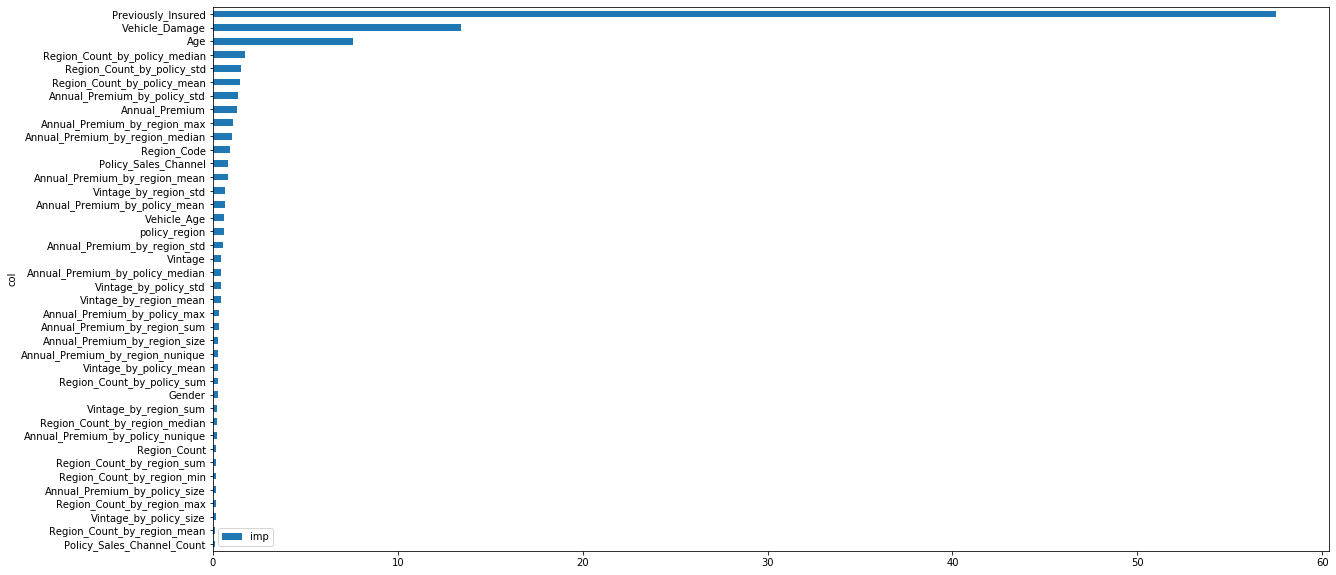

In [203]:
fea_imp = pd.DataFrame({'imp':m.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-40:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
plt.savefig('catboost_feature_importance.png')    